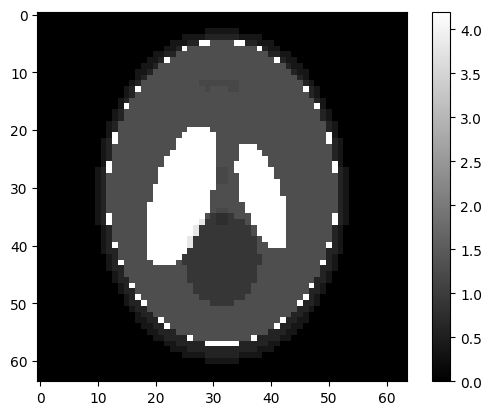

In [41]:
from phantominator import shepp_logan, mr_ellipsoid_parameters
import phantominator
import matplotlib.pyplot as plt
import numpy as np

size=64
E = mr_ellipsoid_parameters()
E[:5, 7] = np.linspace(.1, .9, 5)
pd, t1, t2 = shepp_logan((size, size, 1), MR=True, E=E, zlims=(-.25, -.25))
t1step=(900-250)/len(np.unique(pd))
t2step=(90-1)/len(np.unique(pd))
t1_matrix=np.zeros(pd.shape)
t2_matrix=np.zeros(pd.shape)
for i in range (len(np.unique(pd))):
    t1_matrix[pd==np.unique(pd)[i]]=250 +i*t1step
    t2_matrix[pd==np.unique(pd)[i]]=1 +i*t2step
plt.imshow(t1[:,:,0],cmap="gray");
plt.colorbar()
plt.show()
# print(np.unique(t2_matrix))
# plt.imshow(t2_matrix[:,:,0],cmap="gray")


In [45]:
import numpy as np
import matplotlib.pyplot as plt
class Sequence:
    def __init__(self, total_time : float, te : float, tr : float, flip_angle : float, gx_shifts : int, gy_shifts : int, gy_time : float) -> None:
        self.step=0.001
        self.flip_angle=flip_angle
        self.iters_per_cycle=gy_shifts
        self.time= np.arange(0,total_time+self.step,self.step)
        self.gz=np.zeros(self.time.shape)
        self.gz[(np.arange(0,int(self.time.shape[0]/(tr/self.step)+1)).astype(int)*tr/self.step).astype(int)] =self.flip_angle 
        self.gy=np.zeros(self.time.shape+(gy_shifts,))
        self.gy[int(gy_time/self.step)+(np.arange(0,int(self.time.shape[0]/(tr/self.step)+1)).astype(int)*tr/self.step + gy_time).astype(int)] = np.arange(0,gy_shifts*360,360)
        self.gx=np.zeros(self.time.shape)
        for counter in range(0,gx_shifts): #vectorize            
            self.gx[int(te/self.step)+(np.arange(0,int(self.time.shape[0]/(tr/self.step)+1)).astype(int)*tr/self.step + te).astype(int) +counter] = (360)

    def plot_sequence(self) -> None:
        fig=plt.figure(figsize=(10,5),frameon=True)
        plt.subplots_adjust(wspace=0, hspace=0)

        gz_ax=fig.add_subplot(3,1,1)
        gz_ax.grid()
        gz_ax.set_xticklabels([])
        gy_ax=fig.add_subplot(3,1,2)
        gy_ax.grid()
        gy_ax.set_xticklabels([])
        gx_ax=fig.add_subplot(3,1,3)
        gx_ax.grid()
        gz=self.gz.copy()
        for k in range (1,self.iters_per_cycle):
            gz[np.argwhere(self.gz > 0.0001) + k] = self.gz[np.argwhere(self.gz > 0.0001)]        
        gz[0]=0
        gz_ax.plot(self.time, gz)
        gy=self.gy.copy()
        for i in range (self.iters_per_cycle):
            for j in range (1,self.iters_per_cycle):
                gy[:,i][np.argwhere(np.abs(self.gy[:,i]) > 0.0001) + j] = self.gy[:,i][np.argwhere(np.abs(self.gy[:,i]) > 0.0001)]
            gy_ax.plot(self.time, gy[:,i]);
        gx_ax.plot(self.time, self.gx)
        plt.show()


# sequence=Sequence(total_time = 0.5, te = 0.4, tr = 3, flip_angle = 90, gx_shifts =64, gy_shifts = 64, gy_time= 0.2)
# sequence.plot_sequence()


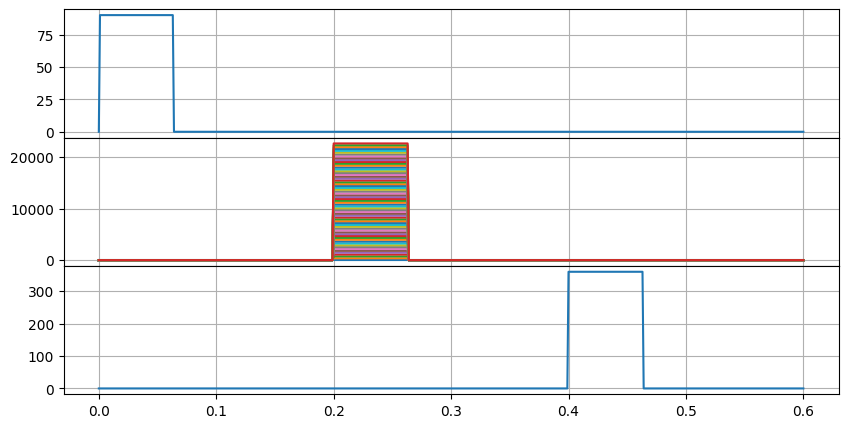

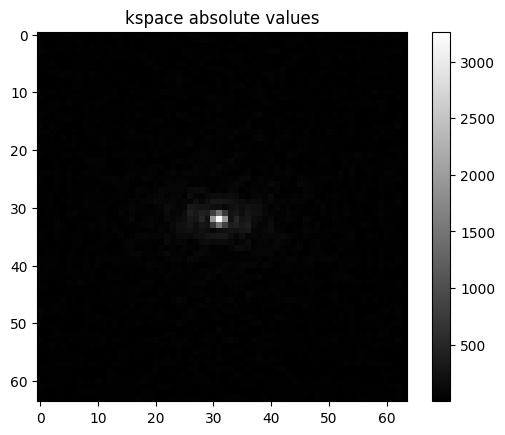

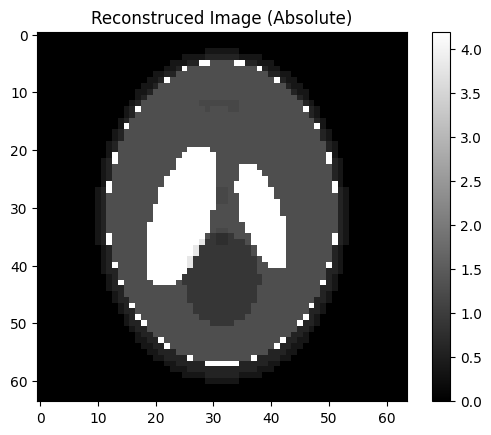

In [52]:
import numpy as np
import math as m
class MRIScan:
    def __init__(self, magnitude_matrix: np.ndarray, t1_matrix: np.ndarray, t2_matrix: np.ndarray) -> None:
        self.protons_matrix = np.concatenate([np.zeros(magnitude_matrix.shape) ,np.zeros(magnitude_matrix.shape), magnitude_matrix],axis=-1)
        self.t1_matrix = t1_matrix 
        self.t2_matrix = t2_matrix 

    def _rx(self, theta: float)  -> np.ndarray:
        theta=np.radians(theta)
        return np.asarray([[ 1, 0           ,  0           ],
                           [ 0, m.cos(theta), -m.sin(theta)],
                           [ 0, m.sin(theta),  m.cos(theta)]])
    
    def _ry(self, theta: float) -> np.ndarray:
        theta=np.radians(theta)
        return np.asarray([[ m.cos(theta), 0, m.sin(theta)],
                           [ 0           , 1, 0           ],
                           [-m.sin(theta), 0, m.cos(theta)]])
    
    def _rz(self, theta: float)  -> np.ndarray:
        theta=np.radians(theta)
        return np.asarray([[ m.cos(theta), -m.sin(theta), 0 ],
                           [ m.sin(theta),  m.cos(theta), 0 ],
                           [ 0           ,  0           , 1 ]])
    

    def rotate_x(self, theta: float) -> None:
        self.protons_matrix = np.squeeze(np.matmul(self._rx(theta), np.expand_dims(self.protons_matrix, axis=(-1))),axis=(-1))

    def rotate_y(self, theta: float) -> None:
        self.protons_matrix = np.squeeze(np.matmul(self._ry(theta), np.expand_dims(self.protons_matrix, axis=(-1))),axis=(-1))

    def rotate_z(self, max_theta: float, row_or_column: bool = False) -> None:
        #0 and max_theta are redundant
        thetas= np.linspace(0, max_theta-max_theta/self.protons_matrix.shape[int(row_or_column)], self.protons_matrix.shape[int(row_or_column)])
        if row_or_column: #broad cast on columns: example shape: (1, 512, 3, 3)
            rotation_matrix= np.asarray([list(map(lambda theta : self._rz(theta), thetas))])
        else: #broad cast on rows: example shape: (512, 1, 3, 3)
            rotation_matrix= np.asarray(list(map(lambda theta :[self._rz(theta)], thetas)))
        self.protons_matrix = np.squeeze(np.matmul(rotation_matrix, np.expand_dims(self.protons_matrix, axis=(-1))),axis=(-1))

    def read_signal(self) -> np.ndarray:
        return (self.protons_matrix[:,:,1] +1j*self.protons_matrix[:,:,0]).sum()


    def apply_sequence(self,sequence: Sequence) -> None:
        protons_matrix_relaxed_copy=self.protons_matrix.copy()
        kspace=np.zeros(self.protons_matrix.shape[0:2],dtype=np.complex_)
        row_counter,column_counter=0,0
        for iter in range(sequence.iters_per_cycle):
            for timer_index in range (len(sequence.time)):
                if np.abs(sequence.gz[timer_index]) > 0.00001:
                    self.rotate_y(theta=sequence.gz[timer_index]) #x or y??
                if sequence.gy[timer_index].any() > 0.00001: #x=rows, y=columns
                    self.rotate_z(max_theta = sequence.gy[timer_index][iter], row_or_column=False) #different theta for every row
                if sequence.gx[timer_index] > 0.00001:
                    self.rotate_z(max_theta = sequence.gx[timer_index], row_or_column=True) #different theta for every column
                    kspace[column_counter,row_counter]=self.read_signal()
                    row_counter+=1            
            column_counter+=1
            row_counter=0
            #relax:
            self.protons_matrix=protons_matrix_relaxed_copy.copy()

        plt.imshow(np.abs((np.fft.fftshift(kspace))),cmap='gray')
        plt.title("kspace absolute values")
        plt.colorbar()
        plt.show()
        # plt.imshow(np.real(np.fft.ifft2((kspace))),cmap='gray')
        # plt.title("image real component")
        # plt.colorbar()
        # plt.show()
        # plt.imshow(np.imag(np.fft.ifft2((kspace))),cmap='gray')
        # plt.title("image imaginary component")
        # plt.colorbar()
        # plt.show()
        plt.imshow(np.abs(np.fft.ifft2((kspace))),cmap='gray')
        plt.title("Reconstruced Image (Absolute)")
        plt.colorbar()
        plt.show()

protons=MRIScan(t1,t1_matrix,t2_matrix)
sequence=Sequence(total_time = 0.6, te = 0.4, tr = 1, flip_angle = 90, gx_shifts = protons.protons_matrix.shape[1], gy_shifts = protons.protons_matrix.shape[0], gy_time= 0.2)
sequence.plot_sequence()
protons.apply_sequence(sequence=sequence)

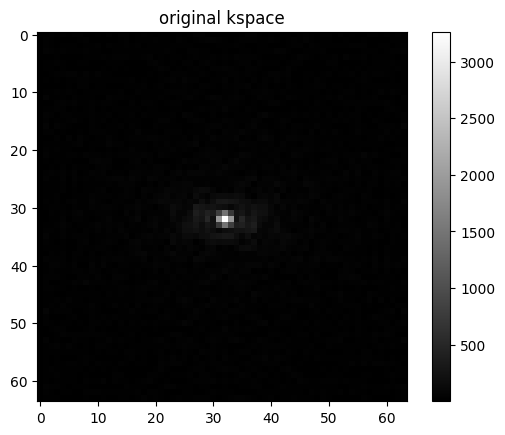

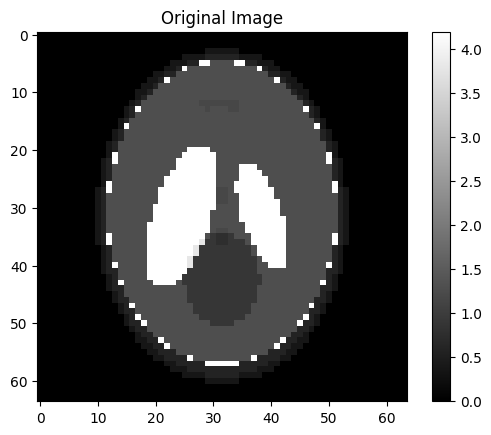

In [51]:
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(t1[:,:,0]))),cmap='gray')
plt.title("original kspace")
plt.colorbar()
plt.show()
plt.imshow(t1[:,:,0],cmap="gray");
plt.title("Original Image")
plt.colorbar()
plt.show()